In [1]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train import train
from src.data.loader_paper import GraphDatasetPaper
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/paper.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDatasetPaper(config = config['config'], split = 'train')
val_dataset = GraphDatasetPaper(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])
    
mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

num_graphs = train_dataset.num_graphs
model = GAE(config, num_graphs).to(device)

# Training

In [2]:
train_dataset[0]

Data(x=[14576], edge_index=[2, 28911], edge_attr=[28911, 2], pos=[14576, 2], edge_weight=[28911])

In [3]:
history = train(model = model, 
                device = device, 
                params = params, 
                train_loader = train_loader, 
                is_val = True,
                val_loader = val_loader, 
                start_up_epoch=50,
                save_best_model=True,
                save_history=True,
                config = config['training'])

train_history, val_history = history

100%|██████████| 2000/2000 [1:16:34<00:00,  2.30s/it, train_loss=0.001395, map_loss=0.000527, reconstruction_loss=0.000869, val_loss=0.001667, val_reconstruction_loss=0.001201, val_map_loss=0.000466]


In [2]:
from src.utils.commons import save_config
save_config(config, task='no_surface')

## Plot train total loss and val total loss

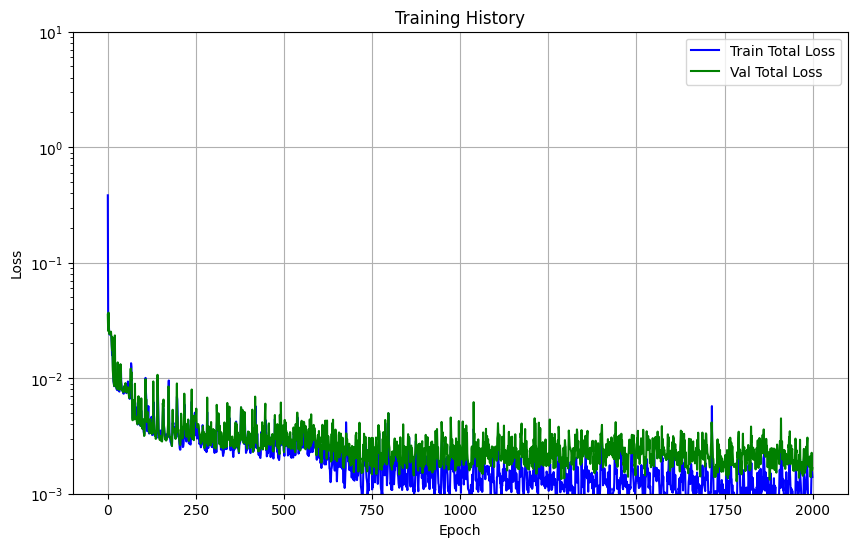

In [4]:
train_total_loss = train_history['train_loss']
val_total_loss = val_history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_total_loss, label='Val Total Loss', color='green')
plt.ylim(0.001, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot train loss history

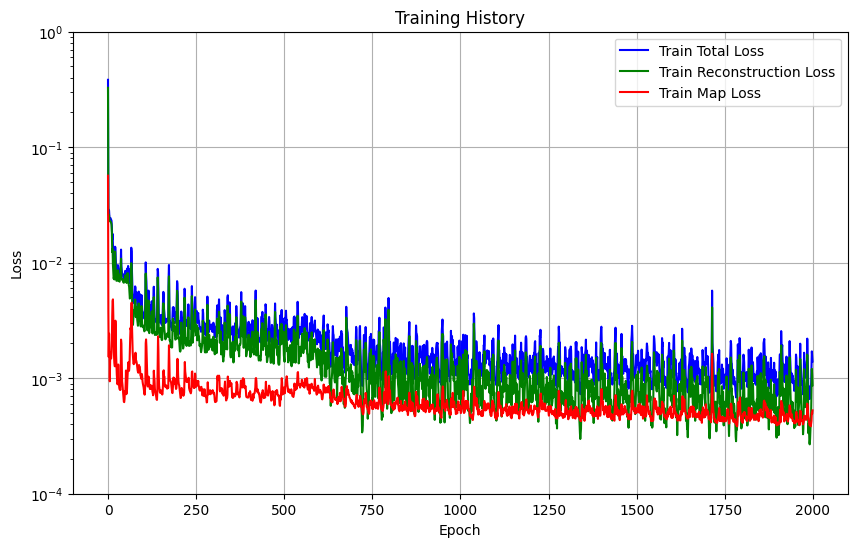

In [13]:
train_total_loss = train_history['train_loss']
train_reconstruction_loss = train_history['reconstruction_loss']
train_map_loss = train_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(train_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(train_map_loss, label='Train Map Loss', color='red')
plt.ylim(0.0001, 1)
# plt.ylim(0.001, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot validation loss history

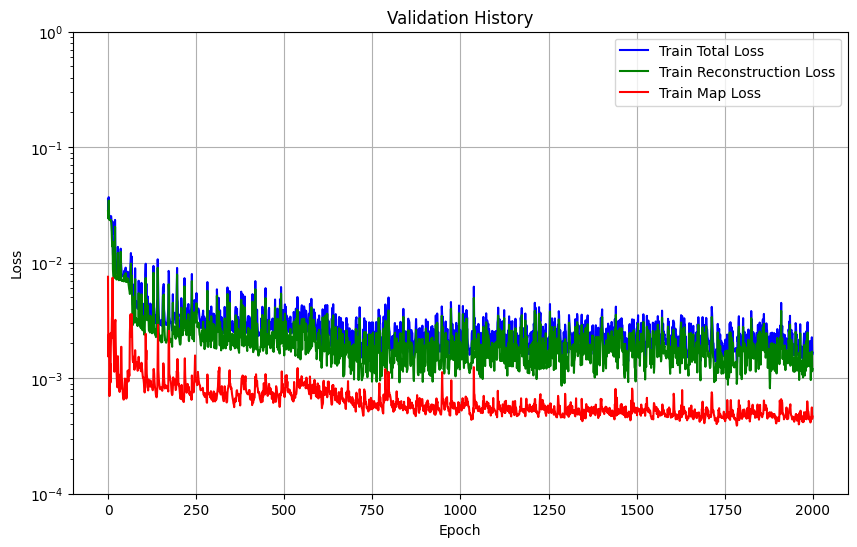

In [14]:
val_total_loss = val_history['val_loss']
val_reconstruction_loss = val_history['reconstruction_loss']
val_map_loss = val_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(val_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(val_map_loss, label='Train Map Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0001, 1)
# plt.ylim(0.001, 10)
plt.title('Validation History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

# Plot results

In [1]:
from src.utils.plot import Plot
from src.utils.commons import load_model
import gc
import numpy as np
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.data.loader_paper import GraphDatasetPaper
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/paper.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDatasetPaper(config = config['config'], split = 'train')
val_dataset = GraphDatasetPaper(config = config['config'], split = 'val')
device = get_device()

mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

model = load_model("artifacts/no_surface/GMM/GMM_best_model_2000.pth", config=config, num_graphs=val_dataset.num_graphs)
model = model.to(device)
plot = Plot(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

## Plot original

Original

Using v_range: 1.1894006729125977


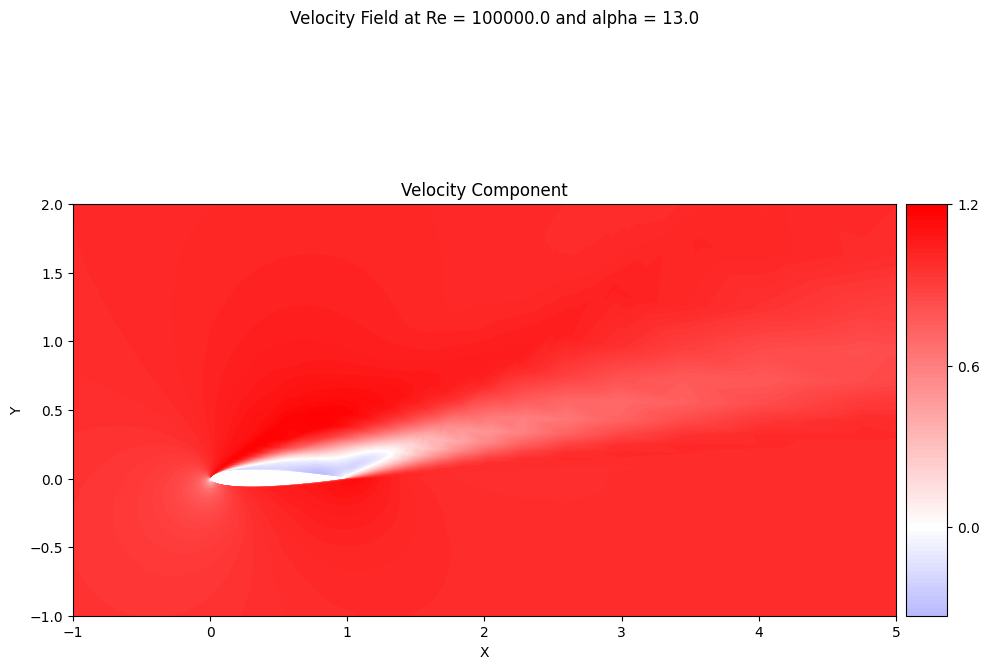

In [12]:
index = 10

test_plot_data = val_dataset[index].to(device)
val_trajectories = val_dataset.file_index[index]
test_param = params[val_trajectories].to(device)

estimated_x, latent_variables, estimated_latent_variables = model(test_plot_data, test_param)
estimated_x = estimated_x.detach().cpu().numpy()
params_detached = params.detach().cpu().numpy()

plot.plot_velocity_field(data=test_plot_data, title=f"Velocity Field at Re = {test_param[0]} and alpha = {test_param[1]}", save=False, xlim=[-1, 5], ylim=[-1, 2], colormap='bwr')

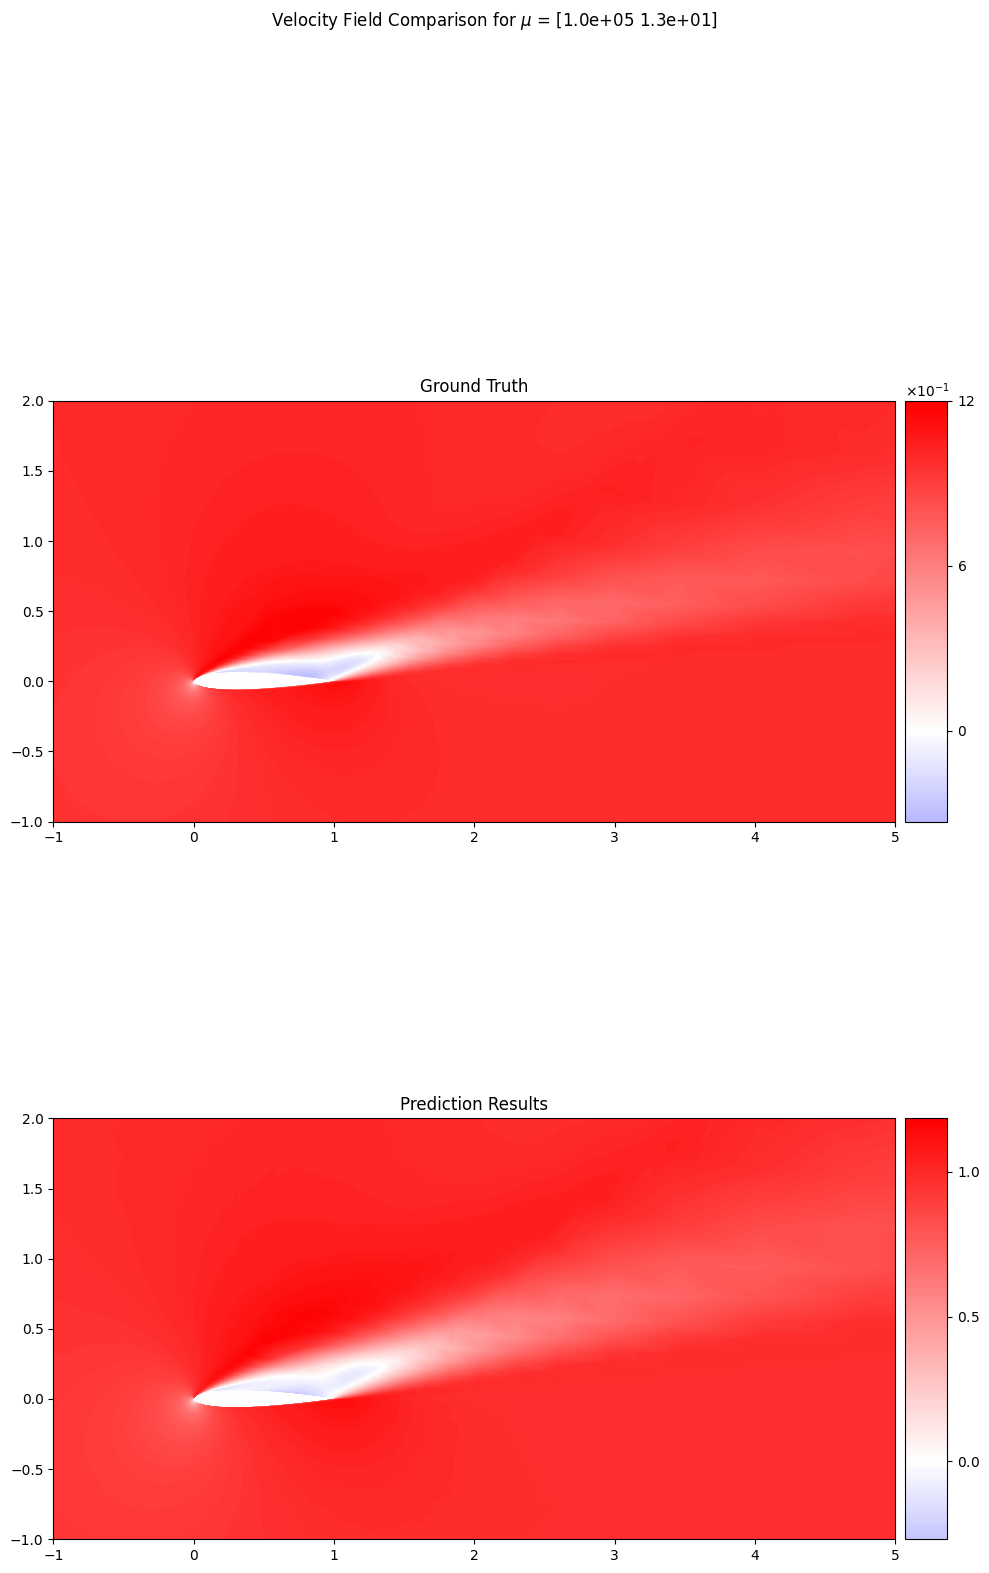

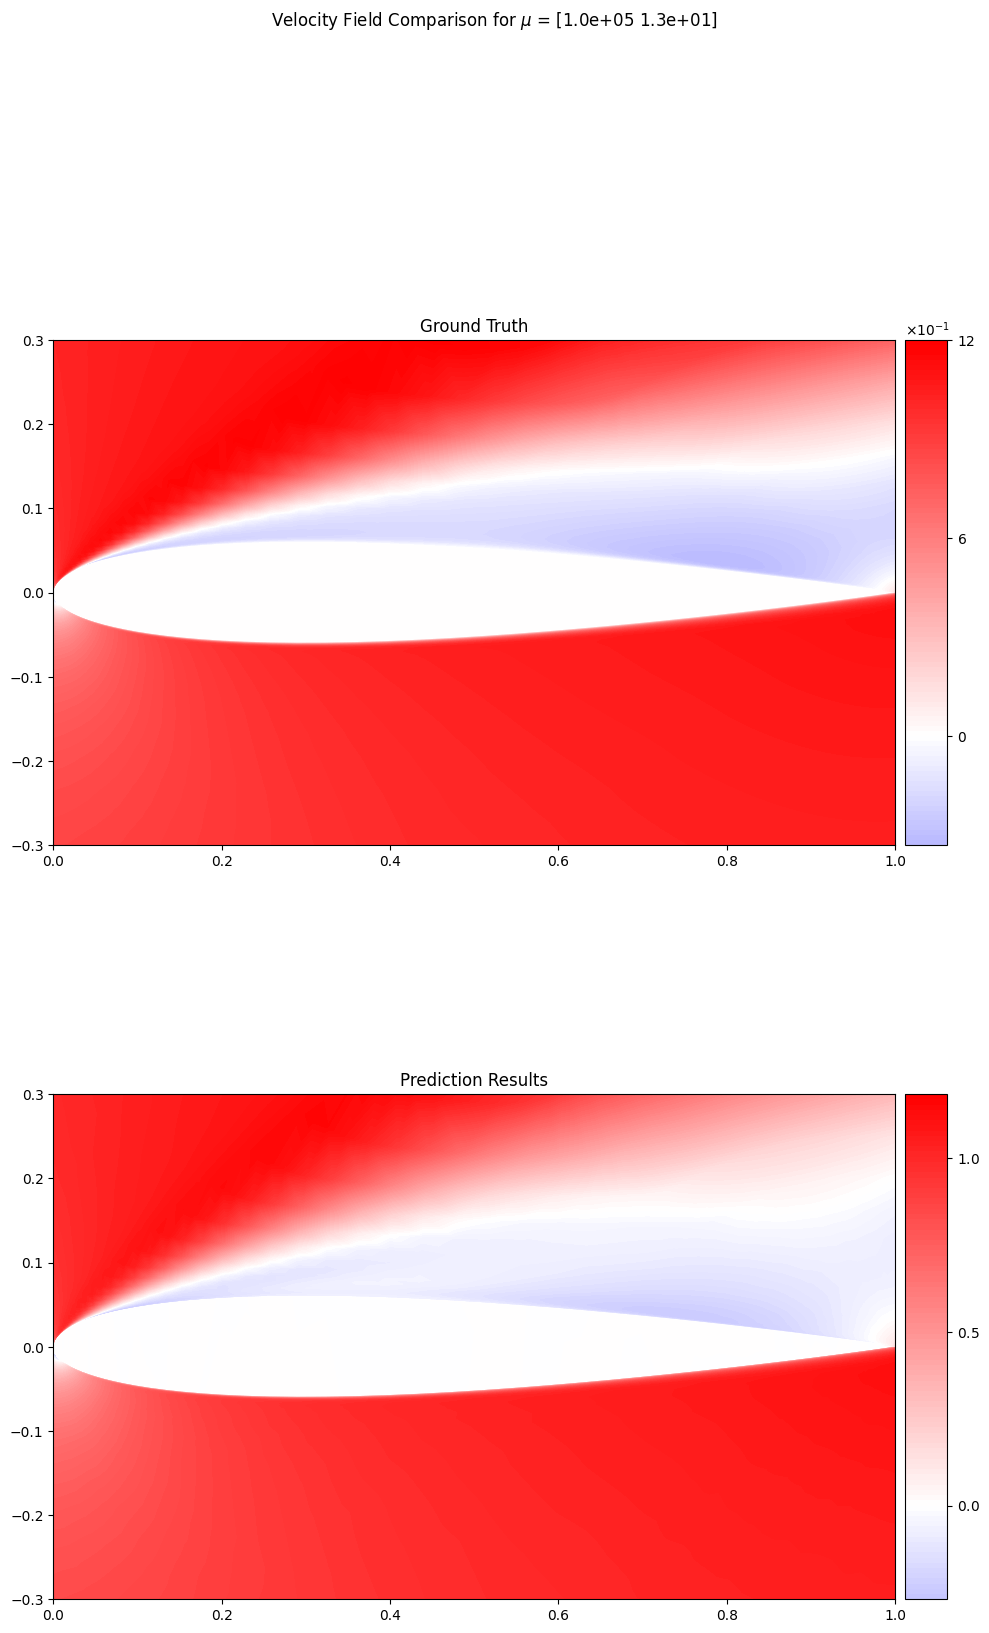

In [19]:
plot.plot_comparison_fields(SNAP = index, device = device, dataset = val_dataset, params = test_param, grid="vertical", colormap='bwr', xlim=[-1, 5], ylim=[-1, 2])

plot.plot_comparison_fields(SNAP = index, 
                            device = device,
                            dataset = val_dataset, 
                            params = test_param, grid="vertical", 
                            colormap='bwr', 
                            # xlim=[-1, 5], ylim=[-1, 2]
                            xlim=[0, 1], ylim=[-0.3, 0.3]
                            )

MSE Error

In [20]:
from torch.nn.functional import mse_loss

error= mse_loss(input=torch.tensor(estimated_x, device=test_plot_data.x.device), target=test_plot_data.x, reduction='mean')
print(f"Mean Squared Error: {error.item()}")

Mean Squared Error: 0.0026102846022695303


Using v_range: 0.17144335806369781


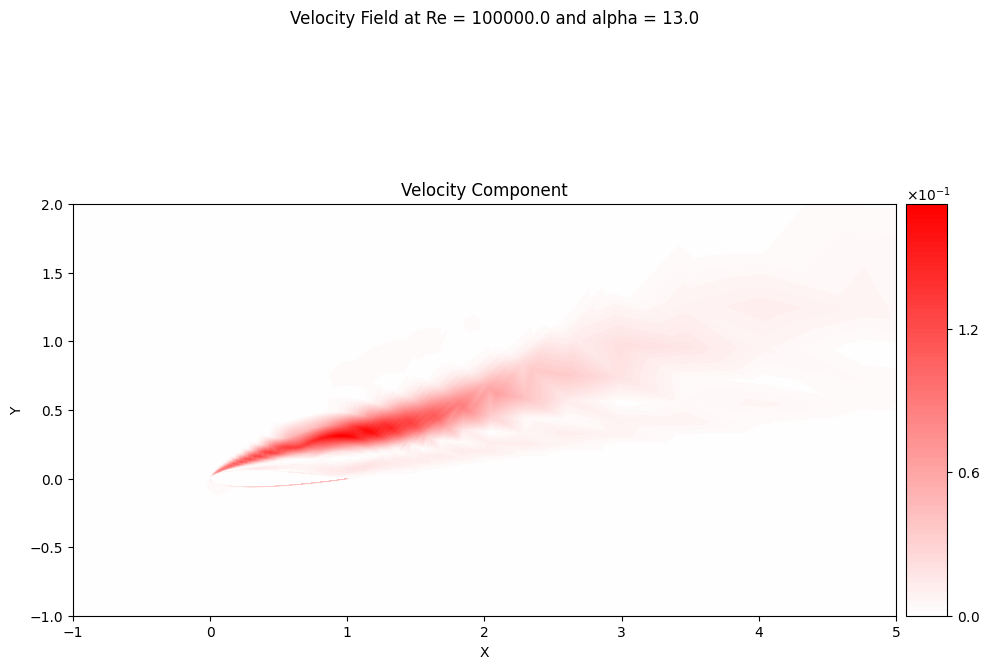

In [17]:
plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"Velocity Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                            #    v_range=[0, 1.5e-1],
                               xlim=[-1, 5], ylim=[-1, 2], 
                               colormap='bwr')

On the airfoil

Using v_range: 0.17144335806369781


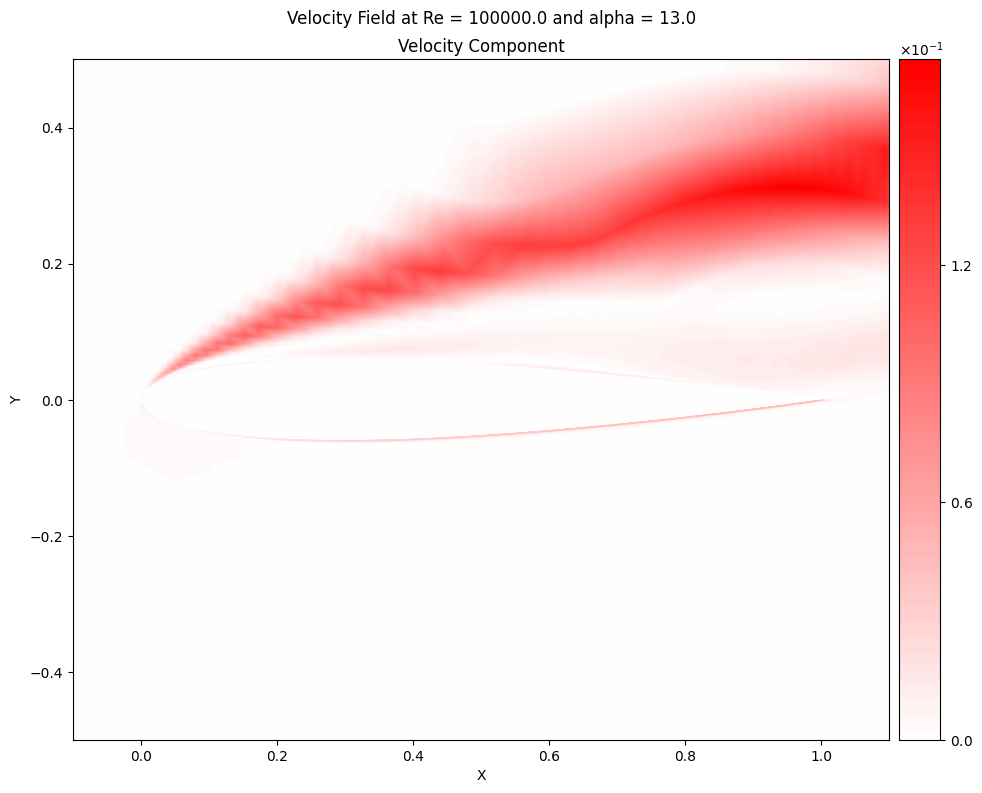

In [15]:
plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"Velocity Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               xlim=[-0.1, 1.1], ylim=[-0.5, 0.5], 
                               colormap='bwr')

On the Boundary Layer

Using v_range: 0.17144335806369781


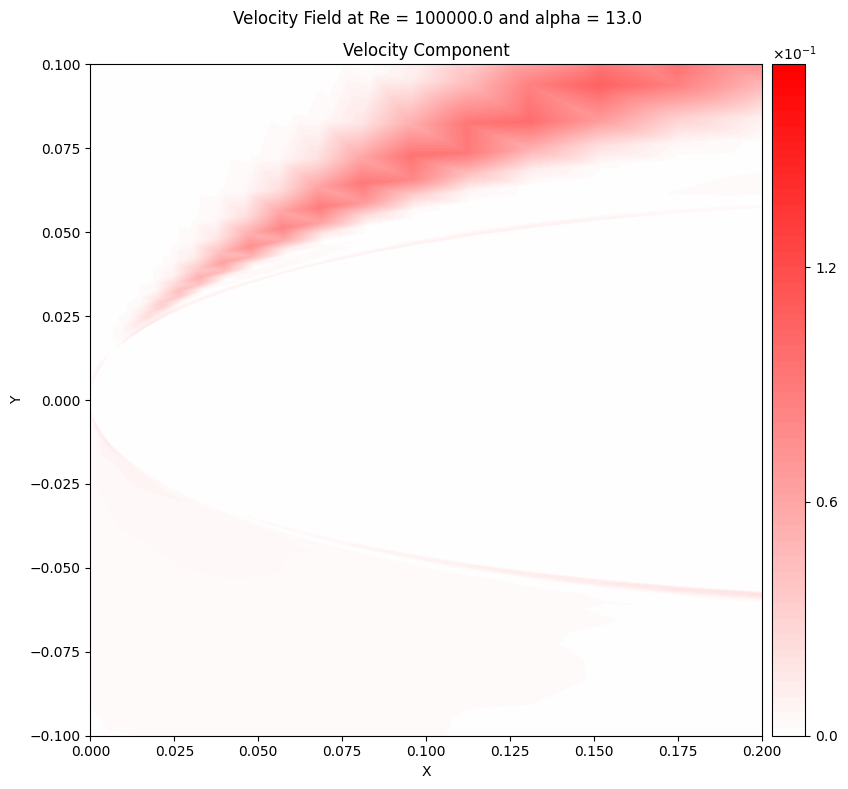

In [18]:
plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"Velocity Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                            #    v_range=[0, 1.5e-1],
                               xlim=[0, 0.2], ylim=[-0.1, 0.1], 
                               colormap='bwr')